## Exploring the variance of POD values across and within terminal categories using ToxValDB 9.4

Created by: Grace Patlewicz <br>
Last modified: 09 November 2023

This notebook explores the question of whether a read-across approach might be feasible within a terminal category by considering the variance across in vivo toxicity studies via the oral and inhalation route. ToxVal data extracted from res_toxval94 stored on local MySQL server. The intent was to extract the POD data from the studies, take the minimum value from a study, take the 10th percentile across studies. Use NOAEL values as is but adjust LOAEL values by a factor of 10. Present the data as box plots and swarm plots coloured coded by chain length. The expectation was that we should be able to see how much variation exists within and across terminal categories of the same root primary category and see how that varies by chain length.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
df = pd.read_excel(interim_dir+'final_universe_categorisations_wCDR_061123.xlsx' , index_col = [0])

In [4]:
df.final_centroid.nunique()

90

In [5]:
universe_ids = df.dtxsid.tolist()

In [6]:
len(universe_ids)

15414

In [7]:
test = universe_ids[:10]

In [8]:
test_str = "' , '" .join(map(str, test))

In [9]:
test_str

"DTXSID6071908' , 'DTXSID8071358' , 'DTXSID1071907' , 'DTXSID001026645' , 'DTXSID301026644' , 'DTXSID6071665' , 'DTXSID1067629' , 'DTXSID801033084' , 'DTXSID1071662' , 'DTXSID1032646"

In [10]:
universe_ids_str = "', '".join(map(str, universe_ids))

In [11]:
import sqlalchemy as sa

In [12]:
username = 'grace'
password = 'graceSQL'
host = '192.168.11.210'


In [13]:
toxval_db = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}/toxval94nov""")

In [14]:
toxval_db.table_names()

/tmp/ipykernel_35180/930175181.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  toxval_db.table_names()


['toxval94nov']

In [15]:
study_types = pd.read_sql('''select distinct(study_type) from toxval94nov  ''', toxval_db)['study_type'].tolist()

In [16]:
 risk_assessment = pd.read_sql('''select distinct(risk_assessment_class) from toxval94nov  ''', toxval_db)['risk_assessment_class'].tolist()

In [17]:
#pd.read_sql('''select distinct(exposure_route) from toxval94nov''', toxval_db)

In [18]:
query = f"select * from toxval94nov where toxval_type in ('NOAEL', 'LOAEL', 'NOAEC', 'LOAEC', 'NOEL', 'LOEL') and dtxsid in ('{universe_ids_str}') and study_type in ('short-term','subchronic', 'chronic', 'developmental', 'reproduction','neurotoxicity', 'neurotoxicity short-term','neurotoxicity subchronic', 'neurotoxicity chronic',  'reproduction developmental','repeat dose', 'repeat dose other', 'immunotoxicity',\
       'reproduction developmental', 'chronic cancer','developmental neurotoxicity', 'carcinogenicity', 'short-term') and exposure_route in ('oral') and toxval_units in ('mg/kg-day')"  

In [19]:
#query

In [20]:
'short-term','subchronic', 'chronic', 'developmental', 'reproduction','neurotoxicity', 'neurotoxicity short-term','neurotoxicity subchronic', 'neurotoxicity chronic',  'reproduction developmental','repeat dose', 'repeat dose other', 'immunotoxicity',\
       'reproduction developmental', 'chronic cancer','developmental neurotoxicity', 'carcinogenicity', 'short-term'

('short-term',
 'subchronic',
 'chronic',
 'developmental',
 'reproduction',
 'neurotoxicity',
 'neurotoxicity short-term',
 'neurotoxicity subchronic',
 'neurotoxicity chronic',
 'reproduction developmental',
 'repeat dose',
 'repeat dose other',
 'immunotoxicity',
 'reproduction developmental',
 'chronic cancer',
 'developmental neurotoxicity',
 'carcinogenicity',
 'short-term')

In [21]:
oral_txval = pd.read_sql(query, toxval_db)

In [22]:
oral_txval.shape

(2802, 110)

In [23]:
query2 = f"select * from toxval94nov where toxval_type in ('NOAEL', 'LOAEL', 'NOAEC', 'LOAEC', 'NOEL', 'LOEL') and dtxsid in ('{universe_ids_str}') and study_type in ('short-term','subchronic', 'chronic', 'developmental', 'reproduction','neurotoxicity', 'neurotoxicity short-term','neurotoxicity subchronic', 'neurotoxicity chronic',  'reproduction developmental','repeat dose', 'repeat dose other', 'immunotoxicity',\
       'reproduction developmental', 'chronic cancer','developmental neurotoxicity', 'carcinogenicity', 'short-term') and exposure_route in ('inhalation') and toxval_units in ('mg/kg-day','mg/m3')"  

In [24]:
inh_txval = pd.read_sql(query2, toxval_db)

In [25]:
inh_txval.shape

(446, 110)

In [26]:
inh_txval['toxval_units'].value_counts()

mg/m3    446
Name: toxval_units, dtype: int64

In [27]:
oral_txval['toxval_units'].value_counts()

mg/kg-day    2802
Name: toxval_units, dtype: int64

In [28]:
oral_txval.study_type.unique()

array(['short-term', 'subchronic', 'chronic', 'developmental',
       'reproduction developmental', 'reproduction', 'neurotoxicity'],
      dtype=object)

In [29]:
inh_txval.study_type.unique()

array(['short-term', 'developmental', 'chronic', 'subchronic',
       'repeat dose other', 'neurotoxicity', 'reproduction'], dtype=object)

In [30]:
oral_txval.dtxsid.nunique()

77

In [31]:
inh_txval.dtxsid.nunique()

28

In [32]:
oral_txval = oral_txval.iloc[:,:70]

In [33]:
inh_txval =inh_txval.iloc[:,:70]

In [34]:
landscape_dict = {k:v for k,v in zip(df['dtxsid'], df['group_str'])}

In [35]:
ch7_dict = {k:v for k,v in zip(df['dtxsid'], df['chain_length'])}

In [36]:
oral_txval['group'] = oral_txval['dtxsid'].replace(landscape_dict)
oral_txval['chain'] = oral_txval['dtxsid'].replace(ch7_dict)

In [37]:
inh_txval['group'] = inh_txval['dtxsid'].replace(landscape_dict)
inh_txval['chain'] = inh_txval['dtxsid'].replace(ch7_dict)

In [38]:
oral_txval = oral_txval[[ 'dtxsid', 'source', 'qc_status','toxval_type','toxval_numeric',
       'toxval_numeric_converted', 'toxval_numeric_standard',
      'toxval_units', 
       'toxval_units_converted', 'toxval_units_standard', 
       'toxval_numeric_qualifier', 
       'study_type', 'group',
       'chain']]

In [39]:
oral_min = oral_txval.groupby(['dtxsid', 'study_type', 'toxval_type', 'group']).agg({'toxval_numeric' :'min'}).reset_index()

In [40]:
oral_min.dtxsid.nunique()

77

In [41]:
oral_min['group'].nunique()

30

In [42]:
study_type_oral = oral_txval.groupby(['dtxsid', 'group', 'toxval_type']).agg({'toxval_type': 'count'}).rename(columns ={'toxval_type': 'count'}).reset_index()

In [43]:
study_type_oral

,dtxsid,group,toxval_type,count
0,DTXSID00223797,"('Silicon PFASs', 'lt7', 2.0, nan)",LOAEL,4
1,DTXSID00223797,"('Silicon PFASs', 'lt7', 2.0, nan)",NOAEL,1
2,DTXSID0034774,"('Side-chain aromatics', 'lt7', 3.0, 3.0)",LOAEL,4
3,DTXSID0034774,"('Side-chain aromatics', 'lt7', 3.0, 3.0)",LOEL,2
4,DTXSID0034774,"('Side-chain aromatics', 'lt7', 3.0, 3.0)",NOAEL,13
...,...,...,...,...
136,DTXSID90870315,"('Other aliphatics', 'lt7', 3.0, 4.0)",LOAEL,7
137,DTXSID90870315,"('Other aliphatics', 'lt7', 3.0, 4.0)",NOAEL,22
138,DTXSID90880131,"('Other aliphatics', 'lt7', 3.0, 4.0)",NOAEL,1
139,DTXSID90880232,"('PFAAs', 'lt7', 2.0, nan)",LOAEL,4


In [44]:
chk_dict = {}
for i, group in study_type_oral.groupby('dtxsid'):
    subset = group[['toxval_type']]
    if subset['toxval_type'].values.any() in ['NOAEL' , 'NOEL']:
        chk_dict[i]  ='N-only'
    elif subset['toxval_type'].values.all() in ['LOAEL' , 'LOEL'] :
        chk_dict[i]  = 'L_only'
    elif subset['toxval_type'].values.any() in ['LOAEL' , 'LOEL','NOAEL' , 'NOEL']:
        chk_dict[i]  = 'both'

In [45]:
#chk_dict

In [46]:
study_type_df = pd.DataFrame(list(chk_dict.items()), columns = ['dtxsid', 'POD_type'])

In [47]:
study_type_df.POD_type.value_counts()

both      43
N-only    34
Name: POD_type, dtype: int64

In [48]:
oral_txval[(oral_txval['dtxsid'] == 'DTXSID7040150') & (oral_txval['study_type'] == 'short-term') & (oral_txval['toxval_type'] == 'NOAEL')]

,dtxsid,source,qc_status,toxval_type,toxval_numeric,toxval_numeric_converted,toxval_numeric_standard,toxval_units,toxval_units_converted,toxval_units_standard,toxval_numeric_qualifier,study_type,group,chain
0,DTXSID7040150,ATSDR PFAS 2021,pass,NOAEL,10.000,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6
1,DTXSID7040150,ATSDR PFAS 2021,pass,NOAEL,10.000,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6
2,DTXSID7040150,ATSDR PFAS 2021,pass,NOAEL,6.100,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6
55,DTXSID7040150,ATSDR PFAS 2021,pass,NOAEL,45.000,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6
56,DTXSID7040150,ATSDR PFAS 2021,pass,NOAEL,25.000,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6
57,DTXSID7040150,ATSDR PFAS 2021,pass,NOAEL,0.050,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6
58,DTXSID7040150,ATSDR PFAS 2021,pass,NOAEL,0.050,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6
1366,DTXSID7040150,ATSDR MRLs 2022,pass,NOAEL,0.006,None,None,mg/kg-day,-,-,=,short-term,"('PFAAs', 'lt7', 4.0, nan)",6


In [49]:
oral_min[oral_min['dtxsid'] == 'DTXSID7040150']

,dtxsid,study_type,toxval_type,group,toxval_numeric
157,DTXSID7040150,chronic,NOAEL,"('PFAAs', 'lt7', 4.0, nan)",0.006
158,DTXSID7040150,short-term,LOAEL,"('PFAAs', 'lt7', 4.0, nan)",5.000
159,DTXSID7040150,short-term,NOAEL,"('PFAAs', 'lt7', 4.0, nan)",0.006
160,DTXSID7040150,subchronic,LOAEL,"('PFAAs', 'lt7', 4.0, nan)",0.300
161,DTXSID7040150,subchronic,NOAEL,"('PFAAs', 'lt7', 4.0, nan)",0.300


In [50]:
res_1 = {}
for i, group in oral_min.groupby(['dtxsid', 'group']):
    subset = group[['toxval_type', 'toxval_numeric']]
    a = list(subset[subset['toxval_type'].isin(['NOAEL', 'NOEC', 'NOEL', 'NOAEC','NEL'])]['toxval_numeric'])
    
    b = list(subset[subset['toxval_type'].isin(['LOAEL', 'LOEC', 'LOEL', 'LOAEC','LEL'])]['toxval_numeric'])
    b = [e/10 for e in b]
    
    if len(a) >0:
        res_1[i] = np.percentile(a, 10)
    elif len(b) > 0:
        res_1[i] = np.percentile(b, 10)
        


In [51]:
S1 = pd.DataFrame(list(res_1.items()), columns = ['a', '10ptile_POD'] )

In [52]:
S1[['dtxsid', 'group']] = pd.DataFrame(S1['a'].tolist(), index=S1.index)
S1.drop('a', axis = 1,  inplace = True)
S1['chl7'] = S1['dtxsid'].replace(ch7_dict)
S1 = S1.sort_values('group', ascending = True)
S1

,10ptile_POD,dtxsid,group,chl7
48,0.8671,DTXSID7027831,"('FASA based PFAA precursors', 'gte7', nan, nan)",8
4,0.3300,DTXSID1032646,"('FASA based PFAA precursors', 'gte7', nan, nan)",8
43,1.0000,DTXSID6027426,"('FASA based PFAA precursors', 'gte7', nan, nan)",8
2,50.0000,DTXSID0067848,"('FASA based PFAA precursors', 'lt7', nan, nan)",4
54,100.0000,DTXSID7070507,"('FASA based PFAA precursors', 'lt7', nan, nan)",4
...,...,...,...,...
32,50.0000,DTXSID50229163,"('Silicon PFASs', 'lt7', 2.0, nan)",6
9,50.0000,DTXSID1074915,"('Silicon PFASs', 'lt7', 2.0, nan)",6
0,50.0000,DTXSID00223797,"('Silicon PFASs', 'lt7', 2.0, nan)",6
27,56.0000,DTXSID4041284,"('unclassified', 'lt7', 1.0, nan)",6


In [53]:
S1.group.nunique()

30

In [54]:
inh_min = inh_txval.groupby(['dtxsid', 'study_type', 'toxval_type', 'group']).agg({'toxval_numeric' :'min'}).reset_index()

In [55]:
inh_min.group.nunique()

14

In [56]:
inh_min

,dtxsid,study_type,toxval_type,group,toxval_numeric
0,DTXSID0061826,developmental,NOAEL,"('Other aliphatics', 'lt7', 3.0, 2.0)",43890.000
1,DTXSID0061826,short-term,LOAEL,"('Other aliphatics', 'lt7', 3.0, 2.0)",43890.000
2,DTXSID0061826,short-term,NOAEL,"('Other aliphatics', 'lt7', 3.0, 2.0)",10920.000
3,DTXSID0061826,subchronic,LOAEL,"('Other aliphatics', 'lt7', 3.0, 2.0)",43890.000
4,DTXSID0061826,subchronic,NOAEL,"('Other aliphatics', 'lt7', 3.0, 2.0)",10920.000
...,...,...,...,...,...
67,DTXSID9038840,subchronic,LOAEC,"('Fluorotelomer PFAA precursors', 'lt7', 2.0, ...",1710.250
68,DTXSID9038840,subchronic,NOAEC,"('Fluorotelomer PFAA precursors', 'lt7', 2.0, ...",171.025
69,DTXSID9041811,short-term,NOAEC,"('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 3.0)",409063.000
70,DTXSID90870315,short-term,NOAEL,"('Other aliphatics', 'lt7', 3.0, 4.0)",169373.000


In [57]:
res_1i = {}
for i, group in inh_min.groupby(['dtxsid', 'group']):
    subset = group[['toxval_type', 'toxval_numeric']]
    a = list(subset[subset['toxval_type'].isin(['NOAEL', 'NOEC', 'NOEL', 'NOAEC','NEL'])]['toxval_numeric'])
    
    b = list(subset[subset['toxval_type'].isin(['LOAEL', 'LOEC', 'LOEL', 'LOAEC','LEL'])]['toxval_numeric'])
    b = [e/10 for e in b]
    
    if len(a) >0:
        res_1i[i] = np.percentile(a, 10)
    elif len(b) > 0:
        res_1i[i] = np.percentile(b, 10)

In [58]:
S1i = pd.DataFrame(list(res_1i.items()), columns = ['a', '10ptile_POD'] )

S1i[['dtxsid', 'group']] = pd.DataFrame(S1i['a'].tolist(), index=S1i.index)
S1i.drop('a', axis = 1,  inplace = True)
S1i['chl7'] = S1i['dtxsid'].replace(ch7_dict)
S1i = S1i.sort_values('group', ascending = True)

In [59]:
S1i['route'] = 'inhalation'
S1['route'] = 'oral'

In [60]:
[e for e in S1i.group.unique().tolist() if e  not in S1.group.unique().tolist()]

["('PFAA precursors', 'lt7', 2.0, nan)"]

In [61]:
S1_all = pd.concat([S1, S1i])


In [62]:
S1_all[S1_all['route'] == 'inhalation'].shape

(28, 5)

In [63]:
S1i.group.unique()

array(["('Fluorotelomer PFAA precursors', 'lt7', 2.0, 1.0)",
       "('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)",
       "('Fluorotelomer PFAA precursors', 'lt7', 3.0, 3.0)",
       "('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 3.0)",
       "('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 1.0)",
       "('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)",
       "('Other aliphatics', 'lt7', 1.0, 1.0)",
       "('Other aliphatics', 'lt7', 1.0, 4.0)",
       "('Other aliphatics', 'lt7', 2.0, 4.0)",
       "('Other aliphatics', 'lt7', 3.0, 2.0)",
       "('Other aliphatics', 'lt7', 3.0, 4.0)",
       "('PFAA precursors', 'lt7', 2.0, nan)",
       "('PFAAs', 'gte7', nan, nan)",
       "('PFAS derivatives', 'lt7', 2.0, 3.0)"], dtype=object)

In [64]:
S1_all.groupby(['group','route']).size()

group                                                route     
('FASA based PFAA precursors', 'gte7', nan, nan)     oral           3
('FASA based PFAA precursors', 'lt7', nan, nan)      oral           4
('Fluorotelomer PFAA precursors', 'gte7', nan, nan)  oral           2
('Fluorotelomer PFAA precursors', 'lt7', 2.0, 1.0)   inhalation     2
                                                     oral           2
('Fluorotelomer PFAA precursors', 'lt7', 2.0, 2.0)   oral           2
('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)   inhalation     3
                                                     oral           3
('Fluorotelomer PFAA precursors', 'lt7', 3.0, 3.0)   inhalation     1
                                                     oral           1
('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 1.0)        oral           1
('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 3.0)        inhalation     1
                                                     oral           1
('Non-PFAA perfluoroalkyls

In [65]:
S1['chl7'].unique()

array([ 8,  4,  6,  1,  2,  3,  7, 13, 17, 12, 10, 11,  9,  5])

In [3]:
S1_all = pd.read_csv(interim_dir+'S1_all_091123.csv', index_col = [0])

In [4]:
S1_all

,10ptile_POD,dtxsid,group,chl7,route
48,0.86710,DTXSID7027831,"('FASA based PFAA precursors', 'gte7', nan, nan)",8,oral
4,0.33000,DTXSID1032646,"('FASA based PFAA precursors', 'gte7', nan, nan)",8,oral
43,1.00000,DTXSID6027426,"('FASA based PFAA precursors', 'gte7', nan, nan)",8,oral
2,50.00000,DTXSID0067848,"('FASA based PFAA precursors', 'lt7', nan, nan)",4,oral
54,100.00000,DTXSID7070507,"('FASA based PFAA precursors', 'lt7', nan, nan)",4,oral
...,...,...,...,...,...
26,169373.00000,DTXSID90870315,"('Other aliphatics', 'lt7', 3.0, 4.0)",3,inhalation
2,37.12410,DTXSID30190948,"('Other aliphatics', 'lt7', 3.0, 4.0)",4,inhalation
8,3.39515,DTXSID4059968,"('PFAA precursors', 'lt7', 2.0, nan)",2,inhalation
20,1.00000,DTXSID8037708,"('PFAAs', 'gte7', nan, nan)",7,inhalation


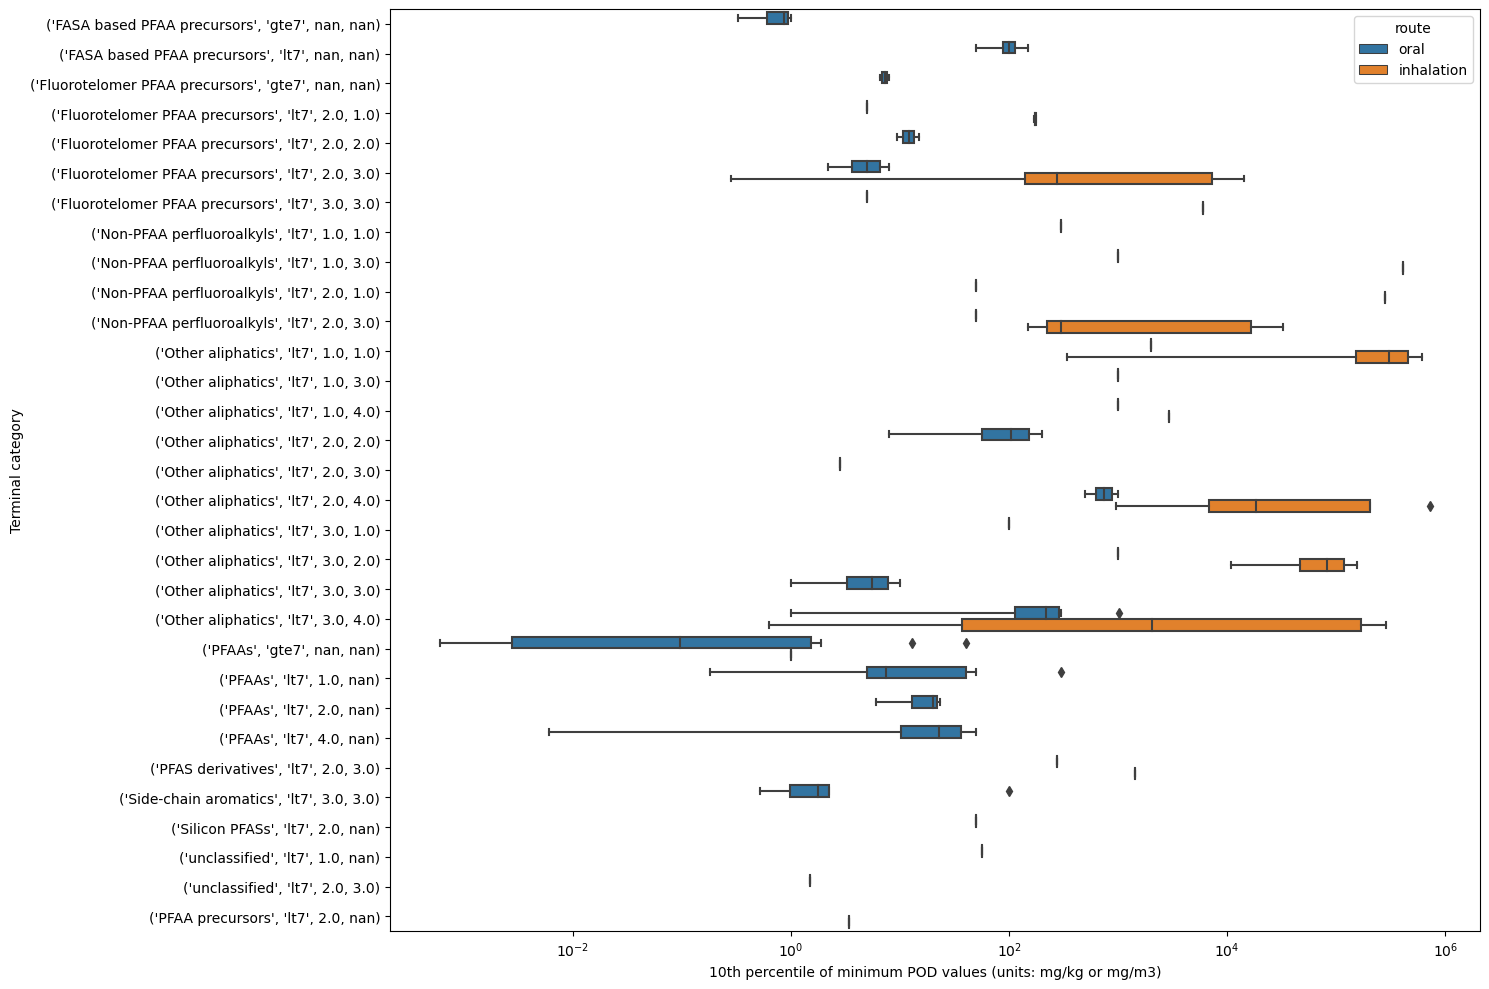

In [10]:
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.boxplot(y= 'group',x = '10ptile_POD', hue = 'route',data = S1_all)
#ax = sns.stripplot(y = S1_all.group, x = S1_all['10ptile_POD'], hue = S1_all['chl7'], data = S1_all)
#ax = sns.stripplot(y = S1i.group, x = S1i['10ptile_POD'], hue = S1i['chl7'], data = S1i)

ax.set_xscale('log')
ax.set_xlabel('10th percentile of minimum POD values (units: mg/kg or mg/m3)')
ax.set_ylabel('Terminal category')
#for xlab in ax.get_yticklabels():xlab.set_rotation(90)
#plt.legend(bbox_to_anchor=(1.3,1), loc='upper right')
plt.tight_layout()  

plt.savefig(figures_dir+'Figure11_inhalation_oral_PODs_261123.png', dpi = 300)

In [67]:
S1[S1['group'] == "('FASA based PFAA precursors', 'gte7', nan, nan)"]

,10ptile_POD,dtxsid,group,chl7,route
48,0.8671,DTXSID7027831,"('FASA based PFAA precursors', 'gte7', nan, nan)",8,oral
4,0.3300,DTXSID1032646,"('FASA based PFAA precursors', 'gte7', nan, nan)",8,oral
43,1.0000,DTXSID6027426,"('FASA based PFAA precursors', 'gte7', nan, nan)",8,oral


In [11]:
S1 = S1_all[S1_all['route'] == 'oral']

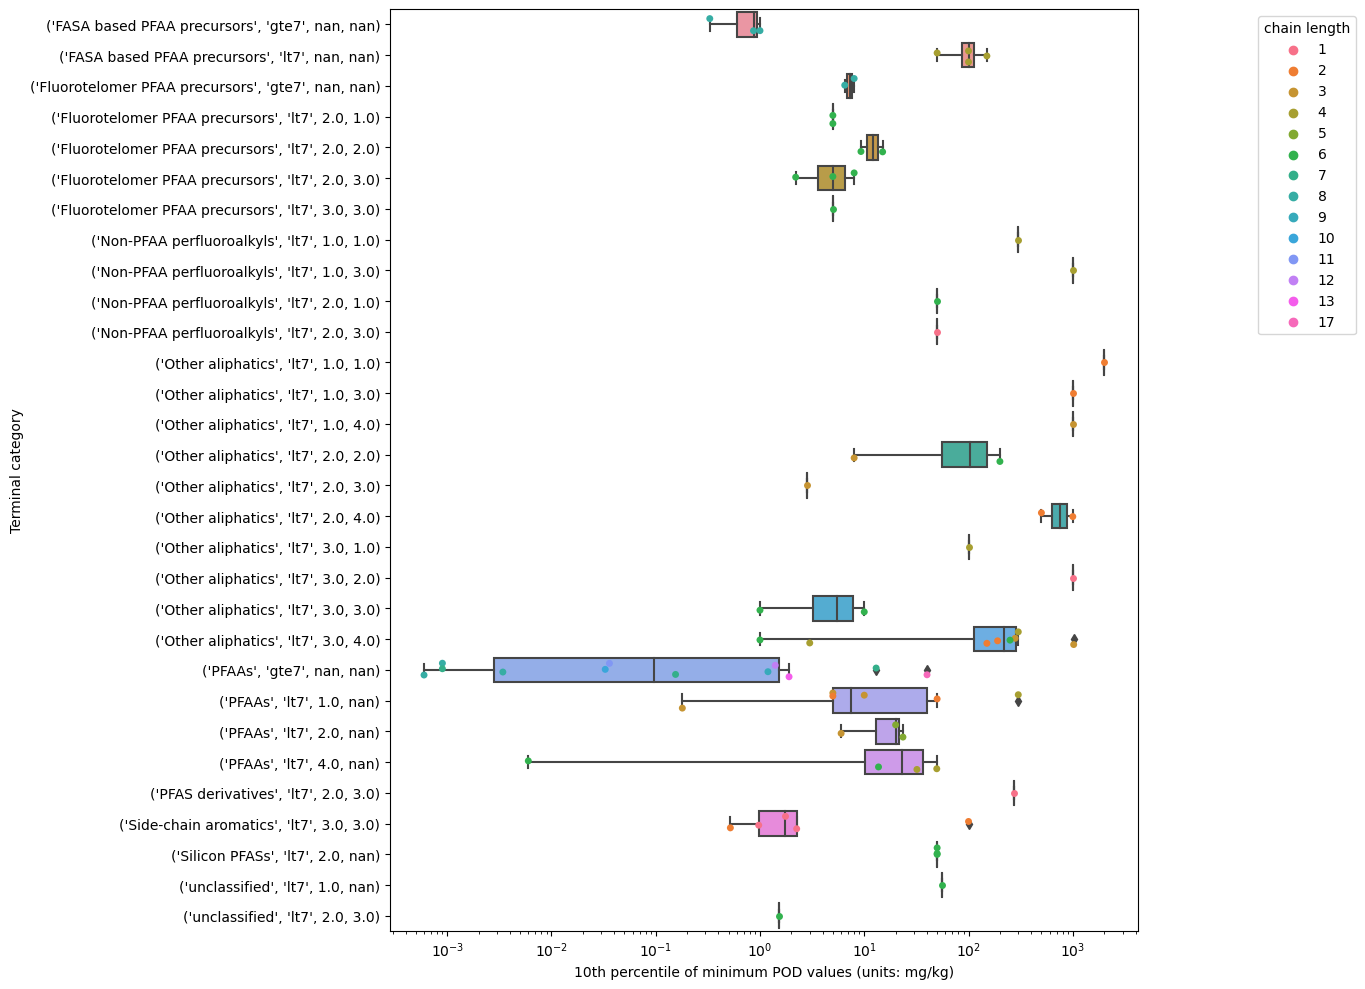

In [12]:
fig2, ax2 = plt.subplots(figsize = (15,10))

ax2 = sns.boxplot(y = S1.group, x = S1['10ptile_POD'], data = S1)
ax2 = sns.stripplot(y = S1.group, x = S1['10ptile_POD'], hue = S1['chl7'].astype('category'), jitter = 0.25,  data = S1)
for patch in ax2.artists:
    r,g,b,a = patch.get_facecolor()
    patch.set_facecolor((r,g,b,0.3))
sns.color_palette("Pastel2")
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2.set_xscale('log')
ax2.set_xlabel('10th percentile of minimum POD values (units: mg/kg)')
ax2.set_ylabel('Terminal category')
#handles, labels = ax2.get_legend_handles_labels()
ax2.legend( title="chain length", loc='upper right', bbox_to_anchor=(1.3,1),)

plt.tight_layout()  
plt.savefig(figures_dir+'ch7_POD_S1_oral_261123.png', dpi = 300)

In [71]:
S1_all.to_csv(interim_dir+'S1_all_091123.csv')